<a href="https://colab.research.google.com/github/serrve1/ubion_project1/blob/main/minmax_kmeans_%EB%9E%9C%EB%8D%A4%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8%EC%85%80%EB%A0%89%EC%85%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# # 한글폰트
# # 나눔고딕 폰트 설치
# !apt-get -qq -y install fonts-nanum > /dev/null
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# # 한글 폰트 설정
# font_name = fm.FontProperties(fname=font_path, size=10).get_name()
# plt.rc('font', family=font_name)

# # 런타임 다시 시작 (이 작업은 Colab에서 한 번만 수행하면 됨)
# # Runtime -> Restart runtime 선택하거나 Ctrl+M . 입력 후 선택

In [ ]:
import warnings

# 경고 메시지를 출력하지 않도록 설정
warnings.filterwarnings("ignore")

# 경고 메시지를 발생시키는 함수
def example_function():
    warnings.warn("이 함수는 예제일 뿐입니다.", UserWarning)

# 함수 호출
example_function()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 기본패키지 설치
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans # 케이민즈 알고리즘
from sklearn.preprocessing import StandardScaler# 스텐다드 스케일러
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc

In [ ]:
# 데이터프레임 불러오기
economics = pd.read_csv('/content/drive/MyDrive/프로젝트1/dataset/resampled_data_final.csv',encoding="euc-kr")
economics['DATE'] = pd.to_datetime(economics['DATE'])
economics['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 289 entries, 0 to 288
Series name: DATE
Non-Null Count  Dtype         
--------------  -----         
287 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.4 KB


In [ ]:
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,M2통화량,신규실업수당청구,경기동행종합,산업생산지수,소매판매
287,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
economics = economics.iloc[:287 , ] # 결측치 제거
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,M2통화량,신규실업수당청구,경기동행종합,산업생산지수,소매판매


In [ ]:
# 2000년~2019년만 군집화하기 위함 , 코로나 데이터가 이상치로 잡히기 때문에 군집이 제대로 형성되지 않음
economics = economics.loc[economics['DATE'].dt.year <=2019 ]

In [ ]:
# 주택가격지수. 제조업신규주문 , 경기동행종합지수는 차분하고 (변동치로 변경한다는 뜻)
# 제조업 신규주문은 앞으로 어떻게 처리할지 일단 보류
#M2와 소매판매는 변화율로 바꾸는 전처리 시행
economics.주택가격지수 = economics.주택가격지수.diff().fillna(method= 'bfill')
economics.경기동행종합 = economics.경기동행종합.diff().fillna(method= 'bfill')
economics['M2차분'] = economics.M2통화량.diff().fillna(method= 'bfill')
economics['M2변화율'] = economics.M2차분/ (economics.M2통화량.shift(1)) * 100
#economics['M2변화율'] .fillna(method = 'ffill')
economics['소매판매차분'] = economics.소매판매.diff().fillna(method='bfill')
economics['소매판매변화율'] = economics.소매판매차분/ (economics.소매판매.shift(1)) * 100


# 차분, 변화율 확인
economics[['M2통화량','M2차분','M2변화율','소매판매','소매판매차분','소매판매변화율']].head(10)
# 결측치를 다음날 데이터로 채워주기
economics['M2변화율'] = economics['M2변화율'].fillna(method = 'bfill')
economics['소매판매변화율'] = economics['소매판매변화율'].fillna(method = 'bfill')
# M2, 소매판매 원데이터를 지웠습니다.
economics.drop(['M2통화량','M2차분','소매판매','소매판매차분'],axis = 1,inplace = True)

In [ ]:
# 다시 날짜를 인덱스로 설정해주기
economics = economics.set_index('DATE')

In [ ]:
# 인덱스 확인
economics.head(3)

,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,신규실업수당청구,경기동행종합,산업생산지수,M2변화율,소매판매변화율
DATE,,,,,,,,,,,,,,,,
2000-01-31,0.92,0.07,27.26,4.00,1636.00,0.57,-0.19,0.58,112.00,5.45,337504.00,288400.00,0.20,91.43,0.28,1.48
2000-02-29,0.64,-0.11,29.37,4.10,1737.00,0.57,-0.20,0.59,111.30,5.73,337504.00,293750.00,0.20,91.74,0.28,1.48
2000-03-31,0.15,-0.47,29.84,4.00,1604.00,0.89,-0.13,0.61,107.10,5.85,370003.00,274750.00,0.43,92.09,0.66,1.17


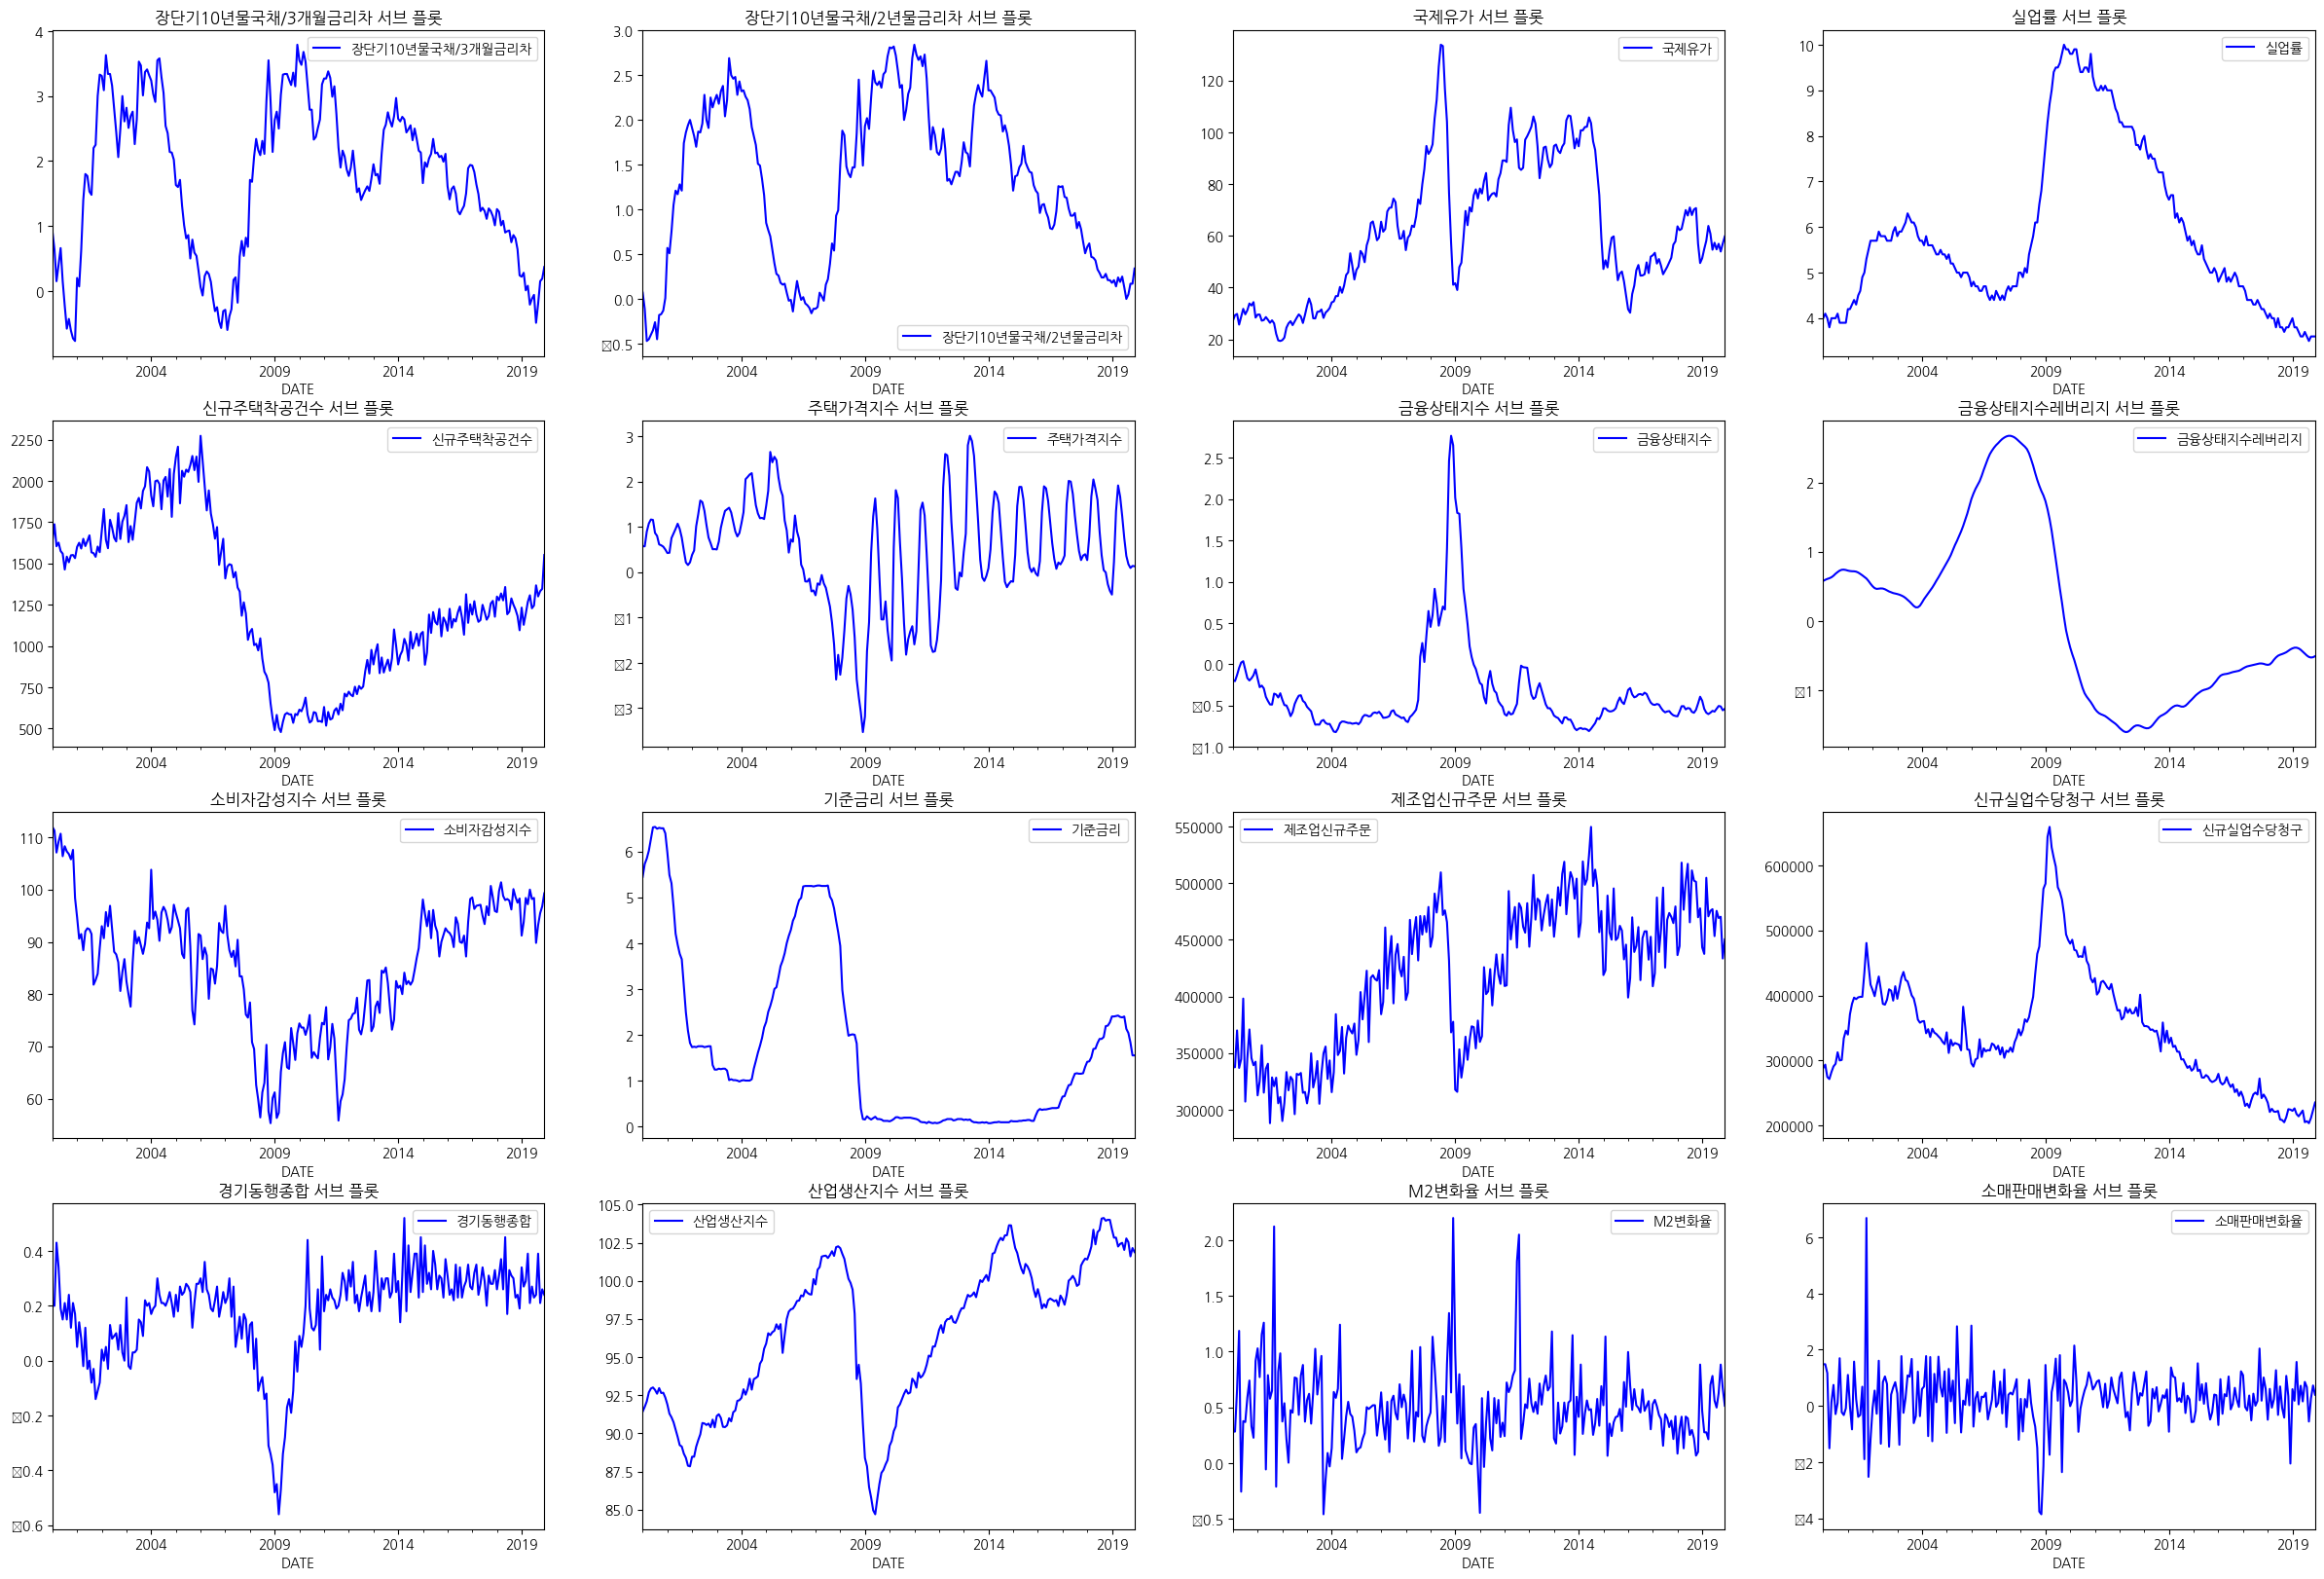

In [ ]:
# 원데이터를 간단하게 시각화 해서 보기
plt.rc('font', family='NanumGothic')
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(economics.columns):
    economics.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()

In [ ]:
economics.describe()

,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,신규실업수당청구,경기동행종합,산업생산지수,M2변화율,소매판매변화율
count,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00
mean,1.74,1.31,61.76,5.88,1265.25,0.47,-0.34,0.09,85.78,1.78,419225.97,346176.88,0.18,96.45,0.50,0.29
std,1.17,0.91,26.14,1.81,467.59,1.19,0.56,1.26,12.26,1.92,63417.80,88961.67,0.17,4.93,0.36,1.01
min,-0.77,-0.47,19.39,3.50,478.00,-3.53,-0.82,-1.60,55.30,0.07,288080.00,203750.00,-0.56,84.69,-0.46,-3.85
25%,0.85,0.45,40.77,4.57,916.50,-0.18,-0.63,-0.98,76.40,0.16,360995.75,284375.00,0.12,92.34,0.28,-0.18
50%,1.90,1.42,58.94,5.40,1214.50,0.51,-0.53,-0.32,88.60,1.15,435075.50,335625.00,0.22,97.62,0.47,0.33
75%,2.64,2.07,82.79,6.83,1633.75,1.30,-0.31,0.73,94.78,2.44,470422.75,398000.00,0.28,100.67,0.64,0.85
max,3.79,2.84,133.88,10.00,2273.00,3.01,2.77,2.67,112.00,6.54,549689.00,659250.00,0.52,104.12,2.20,6.68



#### 스케일링

1. min-max : 0~1까지인데 이건 시간적으로 상승하는데이터는
좋지 않아보임

2. StandardScaler

In [ ]:
# # scikit-learn 패키지의 StandardScaler 클래스를 불러옵니다.
# from sklearn.preprocessing import StandardScaler
# # StandardScaler 객체를 생성합니다.
# standard_scaler = StandardScaler()
# # fit_transform()을 사용해서 학습과 스케일링을 한 번에 적용합니다.
# scaled_eocs = standard_scaler.fit_transform(economics)
# # 표준화가 완료된 데이터를 데이터프레임 형태로 변환합니다.
# scaled_eocs = pd.DataFrame(scaled_eocs,
#                               index=economics.index,
#                               columns=economics.columns)
# # 표준화가 잘 되었는지 데이터를 확인해봅시다.
# scaled_eocs.head()

In [ ]:
# 민멕스 스케일링
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 선언 및 Fitting
mMscaler = MinMaxScaler()
mMscaler.fit(economics)

# 데이터 변환
mMscaled_data = mMscaler.transform(economics)

# 데이터 프레임으로 저장
mMscaled_data = pd.DataFrame(data = mMscaled_data, index = economics.index , columns = economics.columns)

In [ ]:
mMscaled_data.head(3)

,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,신규실업수당청구,경기동행종합,산업생산지수,M2변화율,소매판매변화율
DATE,,,,,,,,,,,,,,,,
2000-01-31,0.37,0.16,0.07,0.08,0.65,0.63,0.18,0.51,1.00,0.83,0.19,0.19,0.70,0.35,0.28,0.51
2000-02-29,0.31,0.11,0.09,0.09,0.70,0.63,0.17,0.51,0.99,0.87,0.19,0.20,0.70,0.36,0.28,0.51
2000-03-31,0.20,0.00,0.09,0.08,0.63,0.68,0.19,0.52,0.91,0.89,0.31,0.16,0.92,0.38,0.42,0.48


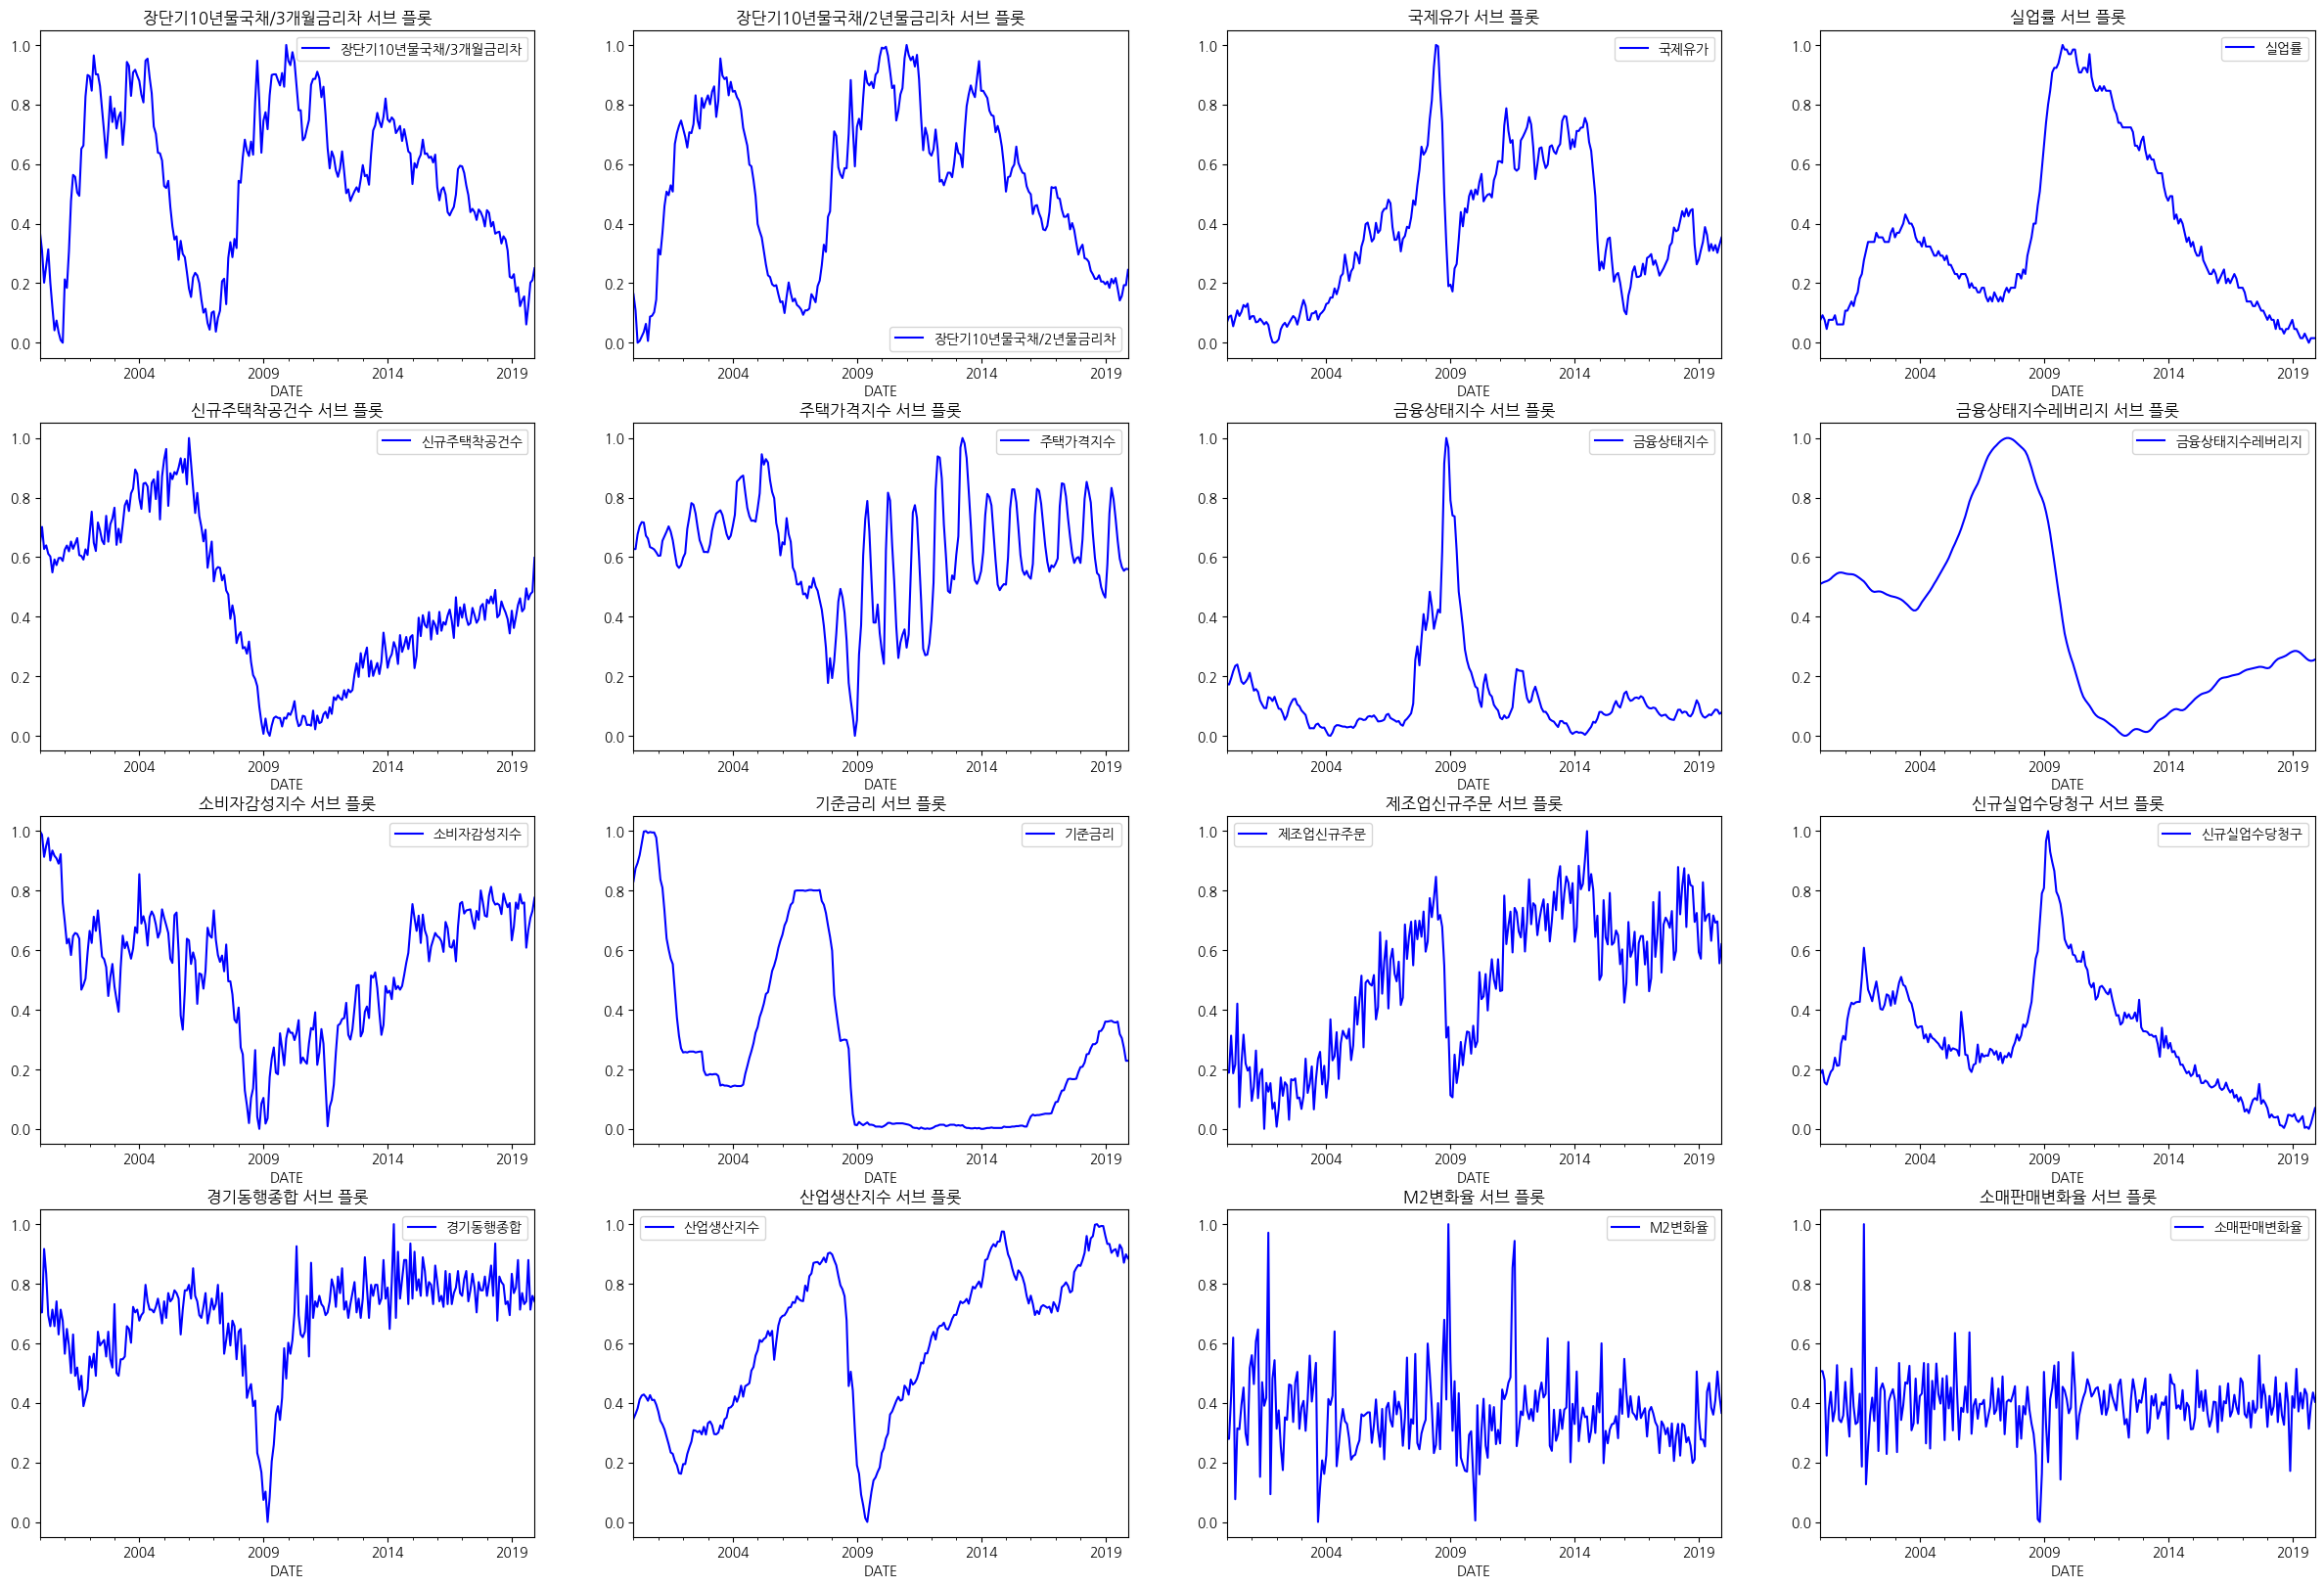

In [ ]:
# 민멕스 스케일링한 데이터를 간단하게 시각화 해서 보기
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(mMscaled_data.columns):
    mMscaled_data.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()

In [ ]:
economics.describe()

,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,신규실업수당청구,경기동행종합,산업생산지수,M2변화율,소매판매변화율
count,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00,240.00
mean,1.74,1.31,61.76,5.88,1265.25,0.47,-0.34,0.09,85.78,1.78,419225.97,346176.88,0.18,96.45,0.50,0.29
std,1.17,0.91,26.14,1.81,467.59,1.19,0.56,1.26,12.26,1.92,63417.80,88961.67,0.17,4.93,0.36,1.01
min,-0.77,-0.47,19.39,3.50,478.00,-3.53,-0.82,-1.60,55.30,0.07,288080.00,203750.00,-0.56,84.69,-0.46,-3.85
25%,0.85,0.45,40.77,4.57,916.50,-0.18,-0.63,-0.98,76.40,0.16,360995.75,284375.00,0.12,92.34,0.28,-0.18
50%,1.90,1.42,58.94,5.40,1214.50,0.51,-0.53,-0.32,88.60,1.15,435075.50,335625.00,0.22,97.62,0.47,0.33
75%,2.64,2.07,82.79,6.83,1633.75,1.30,-0.31,0.73,94.78,2.44,470422.75,398000.00,0.28,100.67,0.64,0.85
max,3.79,2.84,133.88,10.00,2273.00,3.01,2.77,2.67,112.00,6.54,549689.00,659250.00,0.52,104.12,2.20,6.68


In [ ]:
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px


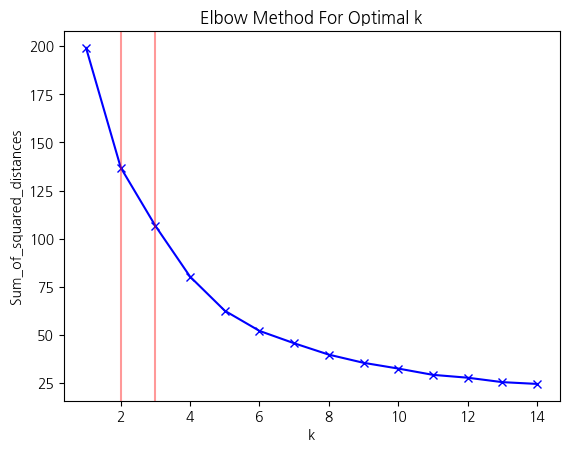

In [ ]:
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(mMscaled_data) # 데이터프레임 입력
    sum_of_squared_distances.append(km.inertia_)

# 시각화

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.axvline(2,c= 'r',alpha =0.4)
plt.axvline(3,c= 'r',alpha =0.4)
plt.show()

In [ ]:
k_range = range(2,14)

best_n = -1
best_silhouette_score = -1

for k in k_range:

  kmeans = KMeans(n_clusters=k, random_state=200)
  kmeans.fit(mMscaled_data)#데이터프레임
  clusters = kmeans.predict(mMscaled_data)#데이터프레임입력

  score = silhouette_score(mMscaled_data, clusters)
  print('k :',  k, 'score :', score)

  if score > best_silhouette_score:
    best_n = k
    best_silhouette_score = score

print('best n :', best_n, 'best score :', best_silhouette_score )

# k-means에서 최적의 k= 6으로 판명

k : 2 score : 0.31685352864735994
k : 3 score : 0.31564143461341204
k : 4 score : 0.36193528677267656
k : 5 score : 0.4022348822013148
k : 6 score : 0.42067545034482035
k : 7 score : 0.40621208289941074
k : 8 score : 0.4202229176639968
k : 9 score : 0.3887874329660599
k : 10 score : 0.38282084109311426
k : 11 score : 0.3829619805170545
k : 12 score : 0.3608623366973736
k : 13 score : 0.36825947689712835
best n : 6 best score : 0.42067545034482035


In [ ]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

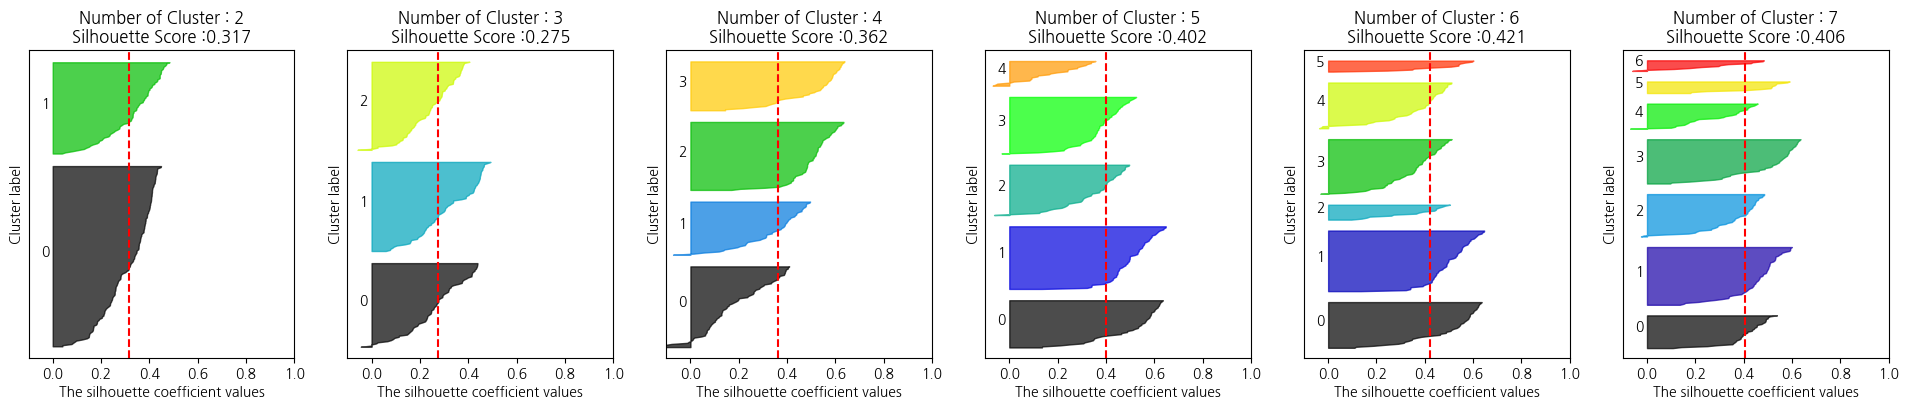

In [ ]:
# 군집 개수 최적화
visualize_silhouette([ 2, 3, 4, 5 , 6, 7], mMscaled_data)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd
import numpy as np

# KMeans
kmeans = KMeans(n_clusters=6, init="k-means++", max_iter=300, random_state=200)
kmeans.fit(mMscaled_data)

# 데이터 프레임에 cluster 추가
mMscaled_data["cluster"] = kmeans.labels_

# 개별 데이터 실루엣 계수
score_samples = silhouette_samples(mMscaled_data, mMscaled_data.cluster)
print(f'silhouette_samples( ) return 값의 shape: {score_samples.shape}')

# 데이터 프레임에 실루엣 계수 추가
mMscaled_data['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수
average_score = silhouette_score(mMscaled_data, mMscaled_data.cluster)
print(f'경제데이터 Silhouette Analysis Score: {average_score:.3f}')



silhouette_samples( ) return 값의 shape: (240,)
경제데이터 Silhouette Analysis Score: 0.614


In [ ]:
mMscaled_data.groupby("cluster").mean()[["silhouette_coeff"]]

,silhouette_coeff
cluster,
0,0.68
1,0.63
2,0.56
3,0.54
4,0.60
5,0.62


In [ ]:
# 0번 군집을 확인해봅니다.
mMscaled_data[mMscaled_data['cluster']== 0]

,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,신규실업수당청구,경기동행종합,산업생산지수,M2변화율,소매판매변화율,cluster,silhouette_coeff
DATE,,,,,,,,,,,,,,,,,,
2014-11-30,0.64,0.66,0.49,0.35,0.29,0.50,0.04,0.10,0.59,0.00,0.64,0.19,0.73,0.98,0.30,0.39,0,0.58
2014-12-31,0.64,0.60,0.35,0.32,0.33,0.51,0.06,0.11,0.68,0.01,0.72,0.18,0.94,0.98,0.43,0.31,0,0.62
2015-01-31,0.53,0.51,0.24,0.34,0.34,0.51,0.08,0.12,0.75,0.01,0.50,0.18,0.75,0.93,0.37,0.31,0,0.64
2015-02-28,0.60,0.56,0.27,0.31,0.23,0.60,0.08,0.12,0.71,0.01,0.52,0.21,0.91,0.90,0.60,0.35,0,0.60
2015-03-31,0.59,0.56,0.25,0.29,0.27,0.76,0.07,0.13,0.66,0.01,0.77,0.18,0.78,0.88,0.20,0.51,0,0.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.06,0.14,0.31,0.02,0.50,0.59,0.08,0.26,0.61,0.32,0.72,0.01,0.74,0.93,0.36,0.43,0,0.65
2019-09-30,0.12,0.16,0.33,0.00,0.46,0.57,0.09,0.25,0.67,0.30,0.69,0.00,0.88,0.92,0.41,0.31,0,0.67
2019-10-31,0.20,0.19,0.30,0.02,0.48,0.55,0.09,0.25,0.71,0.27,0.70,0.02,0.71,0.87,0.51,0.39,0,0.68


In [ ]:
# 각 군집마다 해당되는 월의 개수를 표시해줍니다.
data_list = list(mMscaled_data['cluster'].value_counts())
for i, j  in enumerate(data_list) :
    print(f'{i}번째 클러스터 개수는 {j}개 입니다')

0번째 클러스터 개수는 62개 입니다
1번째 클러스터 개수는 56개 입니다
2번째 클러스터 개수는 47개 입니다
3번째 클러스터 개수는 47개 입니다
4번째 클러스터 개수는 16개 입니다
5번째 클러스터 개수는 12개 입니다


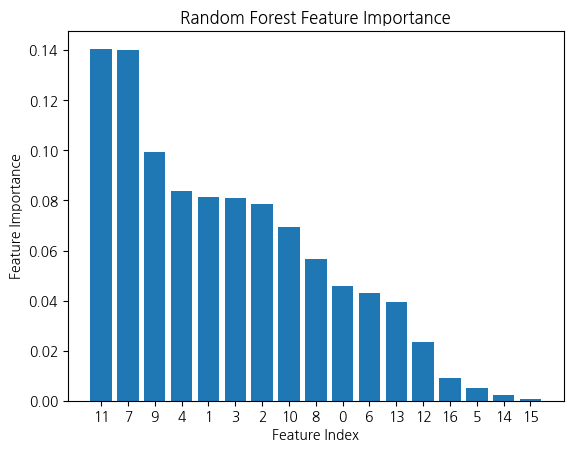

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X = mMscaled_data.copy()
X.drop('cluster', axis=1, inplace=True)
y = mMscaled_data['cluster']  # 레이블을 1차원 배열로 변경

# 랜덤 포레스트 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 학습
rf_model.fit(X, y)

# 피쳐 중요도 확인
feature_importances = rf_model.feature_importances_
rf_model.feature_importances_

# 각 피쳐의 중요도를 내림차순으로 정렬
indices = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k], reverse=True)

# 중요도를 그래프로 시각화
plt.bar(range(X.shape[1]), feature_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

In [ ]:
X.columns # 장단기10년물국채/3개월금리차 = 0번부터
#1,2,3,7,8,9,10,11까지 중요도가 나옴

Index(['장단기10년물국채/3개월금리차', '장단기10년물국채/2년물금리차', '국제유가', '실업률', '신규주택착공건수',
       '주택가격지수', '금융상태지수', '금융상태지수레버리지', '소비자감성지수', '기준금리', '제조업신규주문',
       '신규실업수당청구', '경기동행종합', '산업생산지수', 'M2변화율', '소매판매변화율', 'silhouette_coeff'],
      dtype='object')

## 슬라이싱하고 다시 코드 돌려보기

In [ ]:
mMscaled_data =mMscaled_data[['장단기10년물국채/2년물금리차','국제유가','실업률','금융상태지수레버리지','소비자감성지수','기준금리','제조업신규주문','신규실업수당청구']]
mMscaled_data

,장단기10년물국채/2년물금리차,국제유가,실업률,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,신규실업수당청구
DATE,,,,,,,,
2000-01-31,0.16,0.07,0.08,0.51,1.00,0.83,0.19,0.19
2000-02-29,0.11,0.09,0.09,0.51,0.99,0.87,0.19,0.20
2000-03-31,0.00,0.09,0.08,0.52,0.91,0.89,0.31,0.16
2000-04-30,0.01,0.06,0.05,0.52,0.95,0.92,0.19,0.15
2000-05-31,0.02,0.08,0.08,0.52,0.98,0.96,0.22,0.17
...,...,...,...,...,...,...,...,...
2019-08-31,0.14,0.31,0.02,0.26,0.61,0.32,0.72,0.01
2019-09-30,0.16,0.33,0.00,0.25,0.67,0.30,0.69,0.00
2019-10-31,0.19,0.30,0.02,0.25,0.71,0.27,0.70,0.02


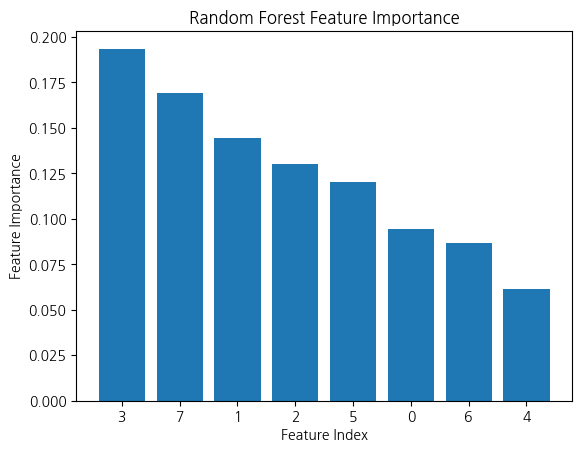

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X = mMscaled_data.copy()
X.drop(['cluster','silhouette_coeff'], axis=1, inplace=True)
y = mMscaled_data['cluster']  # 레이블을 1차원 배열로 변경

# 랜덤 포레스트 모델 생성
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 학습
rf_model.fit(X, y)

# 피쳐 중요도 확인
feature_importances = rf_model.feature_importances_
rf_model.feature_importances_

# 각 피쳐의 중요도를 내림차순으로 정렬
indices = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k], reverse=True)

# 중요도를 그래프로 시각화
plt.bar(range(X.shape[1]), feature_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

In [ ]:
X

,장단기10년물국채/2년물금리차,국제유가,실업률,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,신규실업수당청구
DATE,,,,,,,,
2000-01-31,0.16,0.07,0.08,0.51,1.00,0.83,0.19,0.19
2000-02-29,0.11,0.09,0.09,0.51,0.99,0.87,0.19,0.20
2000-03-31,0.00,0.09,0.08,0.52,0.91,0.89,0.31,0.16
2000-04-30,0.01,0.06,0.05,0.52,0.95,0.92,0.19,0.15
2000-05-31,0.02,0.08,0.08,0.52,0.98,0.96,0.22,0.17
...,...,...,...,...,...,...,...,...
2019-08-31,0.14,0.31,0.02,0.26,0.61,0.32,0.72,0.01
2019-09-30,0.16,0.33,0.00,0.25,0.67,0.30,0.69,0.00
2019-10-31,0.19,0.30,0.02,0.25,0.71,0.27,0.70,0.02


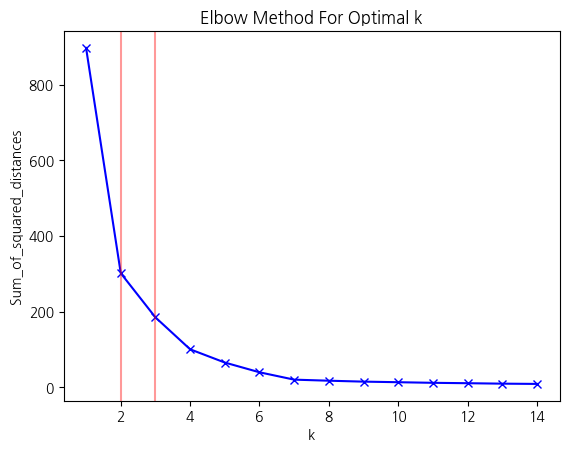

In [ ]:
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(mMscaled_data) # 데이터프레임 입력
    sum_of_squared_distances.append(km.inertia_)

# 시각화

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.axvline(2,c= 'r',alpha =0.4)
plt.axvline(3,c= 'r',alpha =0.4)
plt.show()

In [ ]:
k_range = range(2,14)

best_n = -1
best_silhouette_score = -1

for k in k_range:

  kmeans = KMeans(n_clusters=k, random_state=200)
  kmeans.fit(mMscaled_data)#데이터프레임
  clusters = kmeans.predict(mMscaled_data)#데이터프레임입력

  score = silhouette_score(mMscaled_data, clusters)
  print('k :',  k, 'score :', score)

  if score > best_silhouette_score:
    best_n = k
    best_silhouette_score = score

print('best n :', best_n, 'best score :', best_silhouette_score )
# 최적 k = 7

k : 2 score : 0.5848491495809005
k : 3 score : 0.529305865259989
k : 4 score : 0.5967312100349
k : 5 score : 0.6630873410869721
k : 6 score : 0.6899691405182395
k : 7 score : 0.7221129679583124
k : 8 score : 0.66117712021691
k : 9 score : 0.6440235737137601
k : 10 score : 0.5898869398706902
k : 11 score : 0.5235580218852159
k : 12 score : 0.48504743748864587
k : 13 score : 0.4974642956802031
best n : 7 best score : 0.7221129679583124


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd
import numpy as np

# KMeans, n_clusters= 7 확인
kmeans = KMeans(n_clusters=7, init="k-means++", max_iter=300, random_state=200)
kmeans.fit(mMscaled_data)

# 데이터 프레임에 cluster 추가
mMscaled_data["cluster"] = kmeans.labels_

# 개별 데이터 실루엣 계수
score_samples = silhouette_samples(mMscaled_data, mMscaled_data.cluster)
print(f'silhouette_samples( ) return 값의 shape: {score_samples.shape}')

# 데이터 프레임에 실루엣 계수 추가
mMscaled_data['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수
average_score = silhouette_score(mMscaled_data, mMscaled_data.cluster)
print(f'경제데이터 Silhouette Analysis Score: {average_score:.3f}')



silhouette_samples( ) return 값의 shape: (240,)
경제데이터 Silhouette Analysis Score: 0.727


In [ ]:
mMscaled_data.groupby("cluster").mean()[["silhouette_coeff"]]

,silhouette_coeff
cluster,
0,0.75
1,0.77
2,0.72
3,0.73
4,0.74
5,0.68
6,0.71


In [ ]:
# 각 군집마다 해당되는 월의 개수를 표시해줍니다.
data_list = list(mMscaled_data['cluster'].value_counts())
for i, j  in enumerate(data_list) :
    print(f'{i}번째 클러스터 개수는 {j}개 입니다')

0번째 클러스터 개수는 61개 입니다
1번째 클러스터 개수는 48개 입니다
2번째 클러스터 개수는 46개 입니다
3번째 클러스터 개수는 32개 입니다
4번째 클러스터 개수는 25개 입니다
5번째 클러스터 개수는 16개 입니다
6번째 클러스터 개수는 12개 입니다


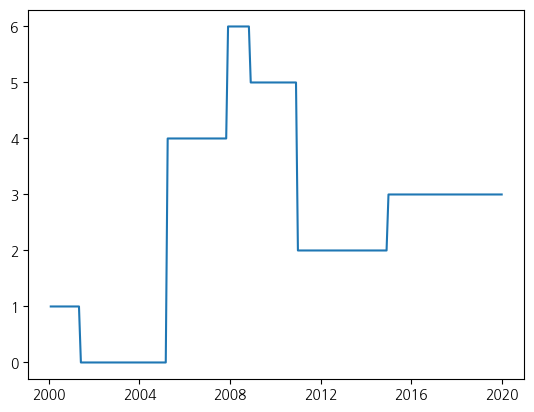

In [ ]:
mMscaled_data.cluster
plt.plot(mMscaled_data.cluster)
plt.show()